In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyLDAvis.sklearn
import re
import seaborn as sns
import spacy
import string
from collections import Counter
from io import StringIO
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from unicodedata import normalize
from wordcloud import WordCloud

# Local directory
ROOT_DIR = os.getcwd()

# NLP
nlp = spacy.load("en_core_web_sm")
stoplist = list(STOP_WORDS)
punctuations = string.punctuation


def load_text_file(filepath):
    f = open(filepath, "r")
    file = []
    for x in f:
        file.append(x)

    raw_text = " ".join([str(x) for x in file])
    df = pd.read_csv(StringIO(raw_text), delimiter="\n")
    df.columns = ["text"]

    return df


df = load_text_file(
    filepath="commission-white-paper-artificial-intelligence-feb2020_en.txt"
)

# Pre-Processing
special_by_space = re.compile('[/(){}\[\]"\|@,;]')


def clean_text(text):
    text = str(text)
    text = text.lower()
    text = text.replace("\n", " ")
    text = special_by_space.sub(" ", text)
    text = " ".join(word for word in text.split() if word not in stoplist)
    return text


def remove_punctuation(text):
    """
     This function remove the replacement_patterns from input string.
     Parameters
     ----------
     text : String
         Input string to the function.
     Returns
     -------
     text : String
         Output string after replacement.
     """
    rem = string.punctuation
    pattern = r"[{}]".format(rem)
    text = re.sub(r"[-()\"#/@;:&<>{}`+=~|.!?,[\]©_*]", " ", text)
    text = text.replace(pattern, "")
    return text


def replace_ptbr_char_by_word(word):
    word = str(word)
    word = normalize("NFKD", word).encode("ASCII", "ignore").decode("ASCII")
    return word


def remove_pt_br_char_by_text(text):
    text = str(text)
    text = " ".join(
        replace_ptbr_char_by_word(word) for word in text.split() if word not in stoplist
    )
    return text


def get_word_frequency(df):
    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=["parser", "ner"])
            tokens = [str(tok).lower().strip() for tok in doc if tok.lemma_ != "-PRON-"]
            tokens = [
                tok for tok in tokens if tok not in stoplist and tok not in punctuations
            ]
            tokens = " ".join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [str(text) for text in df["text"]]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = " ".join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(41)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(41)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18, 6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f"Most Common Words used Brazilian Constitution")
    plt.xticks(rotation=45)
    plt.show()


def show_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stoplist, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for European Commission white paper on AI", fontsize=20)
    plt.axis("off")
    plt.show()


def get_wordcloud(df):
    # Get all texts and generate a cloud
    text = " ".join(str(review) for review in df.text)
    show_wordcloud(text)


def get_tfidf_df(df):
    # This one came from Analytics Vidhya
    # Ref: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

    # Generate the TF
    tf1 = (
        (df["text"][:])
        .apply(lambda x: pd.value_counts(x.split(" ")))
        .sum(axis=0)
        .reset_index()
    )

    tf1.columns = ["word", "tf"]

    # Remove some instances with NaN
    tf1 = tf1.dropna()
    df = df.dropna()

    # Calculate the log of the terms according to the TF
    for i, word in enumerate(tf1["word"]):
        tf1.loc[i, "idf"] = np.log(
            df.shape[0] / (len(df[df["text"].str.contains(word)]))
        )

    # Full calculation of TF-IDF
    tf1["tfidf"] = tf1["tf"] * tf1["idf"]
    return (
        tf1.head(300).sort_values(by=["tfidf"], ascending=False).reset_index(drop=True)
    )


def get_word_ngrams_list(df, word_ngram):
    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:n]

    common_words = get_top_word_n_bigram(df["text"], 20)
    df3 = pd.DataFrame(common_words, columns=["ngram", "qty"])

    return df3


def get_topics(df, n_components, number_words):

    # Convert to list
    data = df.text.values.tolist()

    # Remove special characters
    data = [re.sub("\S*@\S*\s?", "", sent) for sent in data]

    # Remove new line characters
    data = [re.sub("\s+", " ", sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("'", "", sent) for sent in data]

    vectorizer = CountVectorizer(analyzer="word", stop_words=stoplist, lowercase=True)

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum() / data_dense.size) * 100, "%")

    # Build LDA Model
    lda_model = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=10,
        learning_method="online",
        random_state=42,
        batch_size=10,
        evaluate_every=-1,
        n_jobs=-1,
    )
    lda_output = lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(
                " ".join([words[i] for i in topic.argsort()[: -n_top_words - 1 : -1]])
            )

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)

    print_topics(lda_model, vectorizer, number_words)

    return lda_model, data_vectorized, data, lda_output, vectorizer


def get_lda_plot(lda_model, data_vectorized, vectorizer):
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds="tsne")
    return panel


df["text"] = df["text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stoplist)])
)
df["text"] = df["text"].apply(remove_pt_br_char_by_text)
df["text"] = df["text"].apply(clean_text)
df["text"] = df["text"].str.replace("[^\w\s]", "")
df["text"] = df["text"].apply(remove_punctuation)
df["text"] = df["text"].str.strip()
df["text"] = df["text"].str.replace("\d+", "")

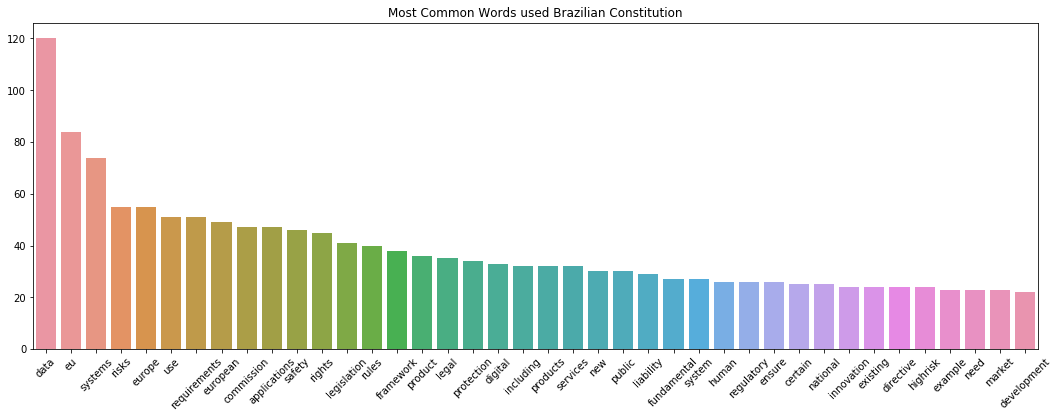

In [2]:
get_word_frequency(df)

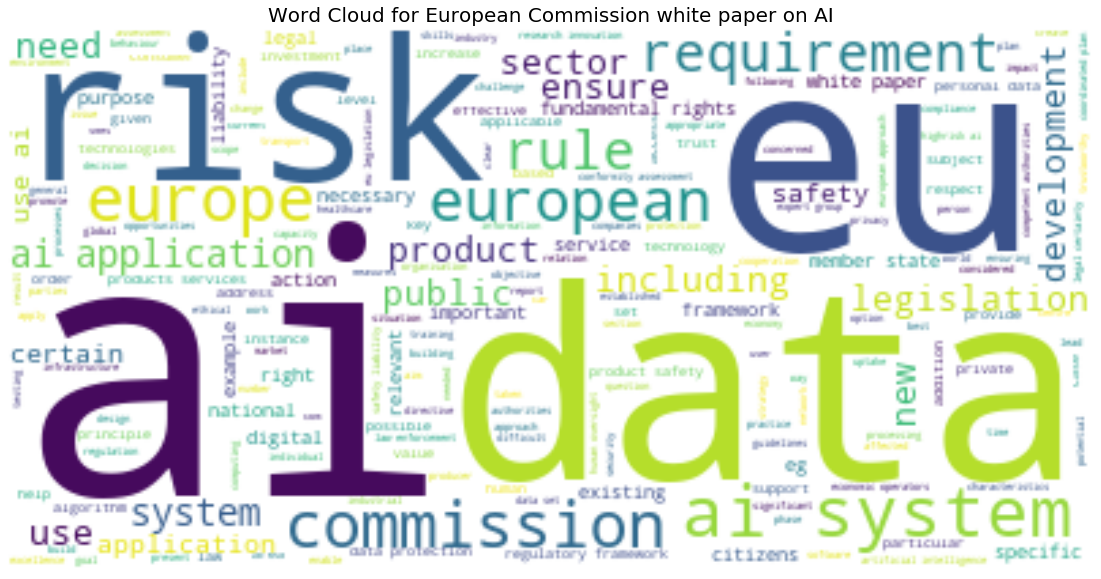

In [3]:
get_wordcloud(df)

In [4]:
df_tfidf = get_tfidf_df(df)
df_tfidf.head(30)

,word,tf,idf,tfidf
0,ai,297.0,1.025950,304.707057
1,data,120.0,2.291616,274.993927
2,systems,74.0,2.661363,196.940868
3,risks,55.0,3.060271,168.314894
4,european,49.0,3.100276,151.913530
5,applications,47.0,3.163455,148.682386
6,rights,45.0,3.230896,145.390334
7,commission,47.0,3.060271,143.832727
8,eu,84.0,1.630804,136.987558
9,use,51.0,2.549445,130.021704


In [5]:
get_word_ngrams_list(df, 2)

,ngram,qty
0,ai systems,46
1,ai applications,30
2,use ai,23
3,fundamental rights,23
4,white paper,19
5,regulatory framework,18
6,member states,16
7,personal data,16
8,data protection,15
9,products services,13


In [6]:
get_word_ngrams_list(df, 3)

,ngram,qty
0,highrisk ai applications,7
1,remote biometric identification,6
2,regulatory framework ai,5
3,highlevel expert group,5
4,digital europe programme,5
5,european approach ai,4
6,accompanying white paper,4
7,future regulatory framework,4
8,eu data protection,4
9,personal data protection,4


In [7]:
lda_model, data_vectorized, data, lda_output, vectorizer = get_topics(
    df, n_components=7, number_words=7
)

get_lda_plot(lda_model, data_vectorized, vectorizer)

Sparsicity:  0.33012385779554543 %
Topics found via LDA:

Topic #0:
europe ensure assessment law economic member conformity

Topic #1:
systems requirements safety product existing information ensuring

Topic #2:
ai data use applications legal national highrisk

Topic #3:
risks products services public certain authorities enforcement

Topic #4:
eu ai commission european rules framework including

Topic #5:
rights protection system relevant particular citizens eg

Topic #6:
legislation ai liability digital need set paper


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2     -29.594002  60.112713       1        1  18.414673
4     -45.996586  11.891685       2        1  17.135963
3      20.368856  70.019325       3        1  13.620988
5      53.928768  31.704309       4        1  12.933470
0     -12.437127 -26.423267       5        1  12.734611
1       3.965971  21.797720       6        1  12.585849
6      37.524284 -16.517805       7        1  12.574447, topic_info=     Category        Freq          Term       Total  loglift  logprob
85    Default  235.000000            ai  235.000000  30.0000  30.0000
470   Default   95.000000          data   95.000000  29.0000  29.0000
1880  Default   61.000000       systems   61.000000  28.0000  28.0000
714   Default   72.000000            eu   72.000000  27.0000  27.0000
1647  Default   48.000000  requirements   48.000000  26.0000  26.0000
...       ...         ...           ...         ...      ...      ...
865    Topic7    6.066350        gender    6.742172   1.9679  -5.0529
647    Topic7    5.969644        enable    6.647154   1.9660  -5.0690
1912   Topic7    5.910210          time    6.587748   1.9650  -5.0790
732    Topic7    5.837769    excellence    6.513027   1.9640  -5.0913
85     Topic7   30.168324            ai  235.176693   0.0200  -3.4489

[256 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
22        7  0.894566    account
26        7  0.895915    achieve
34        5  0.972737     action
35        5  0.903925    actions
48        1  0.931303   addition
...     ...       ...        ...
2000      2  0.941164     values
2022      7  0.887044  voluntary
2041      7  0.926836      white
2046      3  0.933637       work
2051      1  0.887836      world

[238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 6, 1, 2, 7])